In [181]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from mvo_utils_v3 import *
from workspace import OptWorkspace

In [183]:
opt_env = OptWorkspace(10, 1, 1, 0.0, 0.05, universe='spy-sectors')
opt_env.refreshPricing = True
opt_env.print_global_vars()

Global Variables
Refresh Pricing: True
Historical Time Window: 60
Lookback: 10
Rebalance Frequency: W-Sat
Net Exposure: 1
Leverage: 1
Weights: min 0.0 to max 0.05
Universe: fixed-income



In [184]:
if opt_env.refreshPricing:
    opt_env.refresh_sector_px();
    opt_env.refresh_component_px(); # not necessary for asset classes
    opt_env.get_pricing('SPY.csv', ['SPY']);

Getting pricing for: fixed-income.csv 2018-02-13
[*********************100%***********************]  6 of 6 downloaded
Getting pricing for: SPY.csv 2018-02-13
[*********************100%***********************]  1 of 1 downloaded


In [161]:
opt_env.load_companies()
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE','BF.b','BRK.b']
opt_env.drop_companies(remove_tickers)
tickers = opt_env.companies.index.tolist()
print(len(tickers), "companies left for analysis")

Companies loaded: (505, 3)
495 companies left for analysis


In [162]:
px_etfs = opt_env.load_px()
consol_px = opt_env.load_universe_px()[tickers]

Loaded pricing for spy-sectors.csv, with shape (42, 10)
Loaded pricing for XLE-hold-pricing.csv, with shape (42, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (42, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (42, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (42, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (42, 33)
Loaded pricing for XLY-hold-pricing.csv, with shape (42, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (42, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (42, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (42, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (42, 33)


In [163]:
px_etfs = opt_env.load_px()
px_spy = opt_env.load_px('SPY.csv')

Loaded pricing for spy-sectors.csv, with shape (42, 10)
Loaded pricing for SPY.csv, with shape (42, 1)


In [164]:
# calculates optimal gamma
gamma_val, gamma_sr = opt_env.quick_gamma(opt_env.gammaVals, consol_px)
gamma_val, gamma_sr

(199.52623149688787, 6.1628197650537375)

In [179]:
# run portfolio with best net exposure
px_portion, returns, alloc, pdf = opt_env.ls_recommend_allocs(consol_px, gamma_val)
alloc = filter_ls(alloc, 0.01)
recommend = alloc.copy()
tickers = recommend.index.tolist()
companies = opt_env.companies
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
# recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
OXY,0.050000,XLE,Occidental Petroleum
PSX,0.040643,XLE,Phillips 66
NOV,0.050000,XLE,National Oilwell Varco Inc
PCG,0.050000,XLU,PG&E Corporation
EIX,0.050000,XLU,Edison Intl
PPL,0.050000,XLU,PPL Corp
NTAP,0.050000,XLK,NetApp Inc
MON,0.050000,XLB,Monsanto Co.
NEM,0.050000,XLB,Newmont Mining Corp
GIS,0.050000,XLP,General Mills Inc


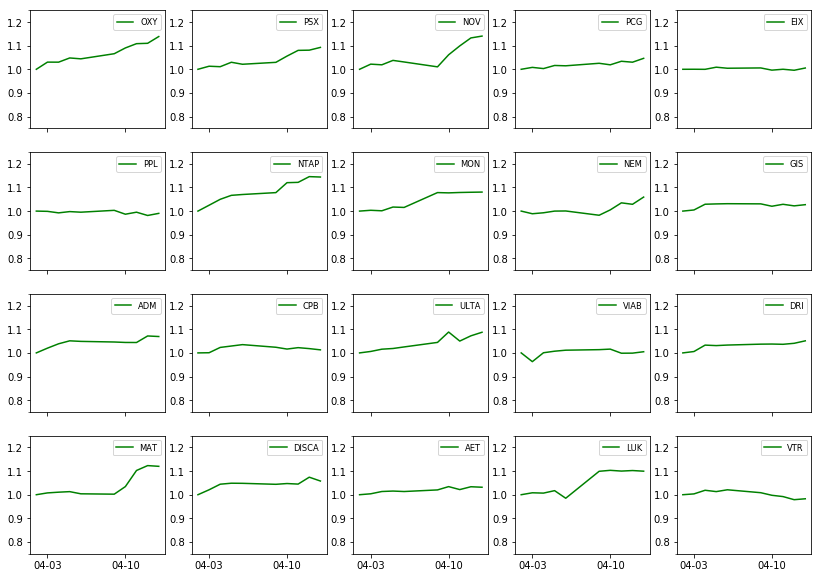

In [166]:
plot_chart_grid(consol_px, recommend, 'Allocation', opt_env.lookback, tickers)

In [167]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False).round(2)

Total % Allocation 98.21


,Sector Weight,Avg Position
XLY,0.22,0.04
XLU,0.15,0.05
XLP,0.15,0.05
XLE,0.14,0.05
XLB,0.10,0.05
XLRE,0.10,0.05
XLK,0.05,0.05
XLV,0.05,0.05
XLF,0.02,0.02


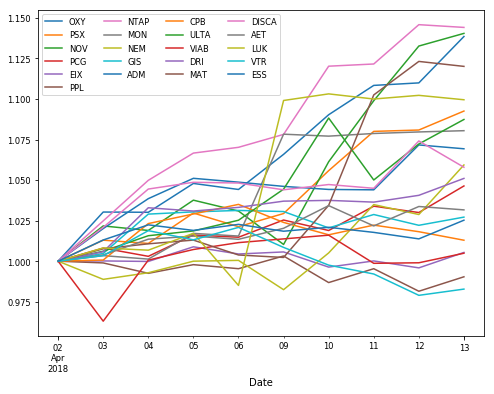

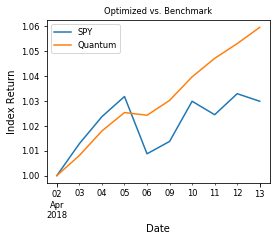

In [168]:
port_pos_idx = compound(consol_px[-opt_env.lookback:][recommend.index])
ax = port_pos_idx.plot(fontsize='small', figsize=(8,6))
ax.legend(fontsize='small', ncol=4)
idx_px_spy = compound(px_spy.loc[port_pos_idx.index])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

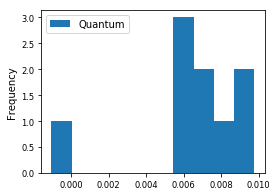

In [169]:
pdf.pct_change().plot(kind='hist', figsize=(4,3), fontsize='small')

In [178]:
# Outputs for trade execution
trading_df = get_trading(220000, consol_px, tickers, opt_env.lookback, alloc, recommend)
pprint.pprint(summary_stats(consol_px, tickers, opt_env.lookback, alloc, recommend, trading_df))
if opt_env.refreshPricing: opt_env.save_recommendation(trading_df)    
trading_df

{'Date': '2018-04-13',
 'Long': 21,
 'Long Exposure': 0.9821361130106544,
 'Net Dollar Exposure': 216051,
 'Positions': 21,
 'Return (Ann)': 0.0575098382382244,
 'Risk (Vol)': 0.009331741058587154,
 'Sharpe Ratio': 6.1628197650537375,
 'Short': 0,
 'Short Exposure': 0.0,
 'Total Allocation': 98.21361130106546}


,Company,Price,Allocation,Dollar Value,Shares
ADM,Archer-Daniels-Midland Co,45.200001,0.050000,10999,243
AET,Aetna Inc,172.929993,0.050000,10999,63
CPB,Campbell Soup Co,42.450001,0.050000,10999,259
DISCA,Discovery Communications Inc A,22.830000,0.050000,10999,481
DRI,Darden Restaurants Inc,87.720001,0.050000,10999,125
EIX,Edison Intl,63.439999,0.050000,10999,173
ESS,Essex Property Trust,242.990005,0.050000,10999,45
GIS,General Mills Inc,44.799999,0.050000,10999,245
LUK,Leucadia National Corp (NY),24.299999,0.017874,3932,161
MAT,Mattel Inc,14.640000,0.049008,10781,736
